In [1]:
from res.plot_lib import plot_data, plot_model, set_default

In [2]:
set_default()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += 1
    return np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
input_size = 28*28 # image of 28*28 pixels
output_size = 10 # 10 classes, num 0-9

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])),
    batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ]), download=False),
    batch_size=1000, shuffle=True
)

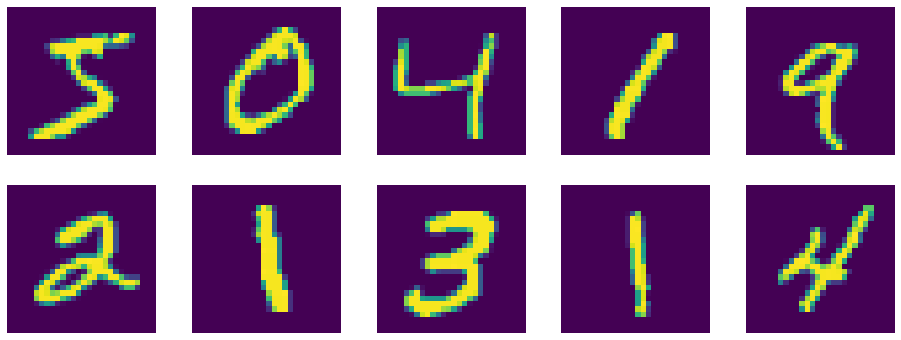

In [6]:
# show images
plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    image,_ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [7]:
class FC2Layer(nn.Module):
    def __init__ (self, input_size, n_hidden, output_size):
        super().__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super().__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50,10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [8]:
## Running on GPU
accuracy_list = []

def train(epoch, model, perm=torch.arange(0,784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1,1,28,28)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print (f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100*batch_idx/len(train_loader)}%)]")
            print (f"Loss: {loss.item():.6f}")

def test(model, perm = torch.arange(0,784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        data = data.view(-1,28*28)
        data = data[:,perm]
        data = data.view(-1,1,28,28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100* correct/len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print (f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

In [9]:
## Training the FC network

n_hidden = 8

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr = 0.01, momentum = 0.5)
print (f"Number of parameters: {get_n_params(model_fnn)}.")

for epoch in range(0,1):
    train(epoch,model_fnn)
    test(model_fnn)

Number of parameters: 6.
Train Epoch: 0 [0/60000 (0.0%)]
Loss: 2.352704
Train Epoch: 0 [6400/60000 (10.660980810234541%)]
Loss: 1.872741
Train Epoch: 0 [12800/60000 (21.321961620469082%)]
Loss: 0.965144
Train Epoch: 0 [19200/60000 (31.982942430703623%)]
Loss: 0.732330
Train Epoch: 0 [25600/60000 (42.643923240938165%)]
Loss: 0.570967
Train Epoch: 0 [32000/60000 (53.304904051172706%)]
Loss: 0.479185
Train Epoch: 0 [38400/60000 (63.96588486140725%)]
Loss: 0.354508
Train Epoch: 0 [44800/60000 (74.6268656716418%)]
Loss: 0.517757
Train Epoch: 0 [51200/60000 (85.28784648187633%)]
Loss: 0.349734
Train Epoch: 0 [57600/60000 (95.94882729211088%)]
Loss: 0.500617

Test set: Average loss: 0.3800, Accuracy: 8907/10000 (89%)



In [10]:
## Training the ConvNet

n_features = 6

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(),lr = 0.01, momentum = 0.5)
print (f"Number of parameters: {get_n_params(model_cnn)}")

for epoch in range(0,1):
    train (epoch, model_cnn)
    test (model_cnn)

Number of parameters: 8
Train Epoch: 0 [0/60000 (0.0%)]
Loss: 2.341944
Train Epoch: 0 [6400/60000 (10.660980810234541%)]
Loss: 2.201964
Train Epoch: 0 [12800/60000 (21.321961620469082%)]
Loss: 0.612177
Train Epoch: 0 [19200/60000 (31.982942430703623%)]
Loss: 0.515302
Train Epoch: 0 [25600/60000 (42.643923240938165%)]
Loss: 0.311576
Train Epoch: 0 [32000/60000 (53.304904051172706%)]
Loss: 0.323876
Train Epoch: 0 [38400/60000 (63.96588486140725%)]
Loss: 0.161098
Train Epoch: 0 [44800/60000 (74.6268656716418%)]
Loss: 0.363872
Train Epoch: 0 [51200/60000 (85.28784648187633%)]
Loss: 0.171908
Train Epoch: 0 [57600/60000 (95.94882729211088%)]
Loss: 0.188219

Test set: Average loss: 0.2080, Accuracy: 9353/10000 (94%)



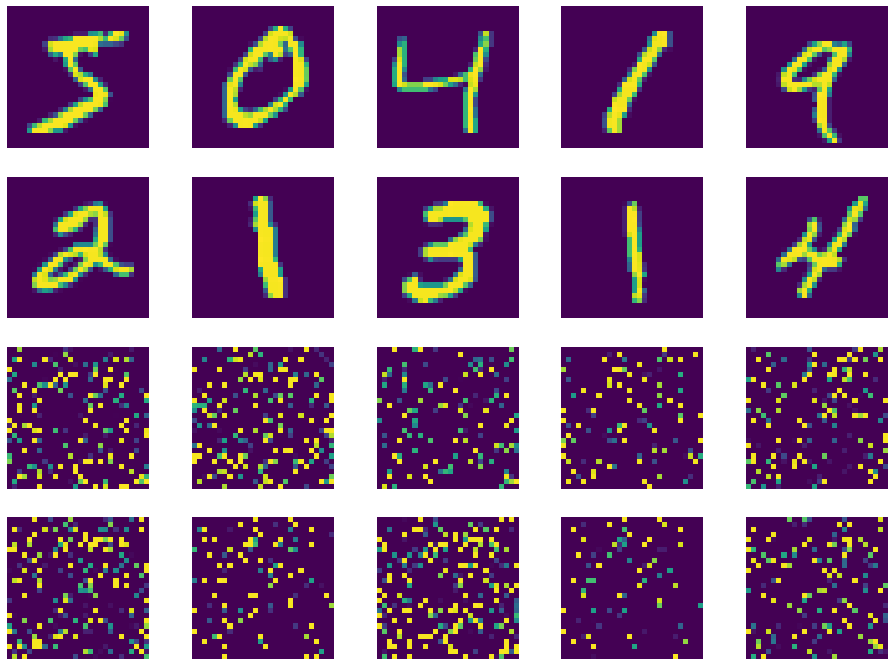

In [11]:
# Changing the assumptions: inputs no-longer heirarchical

perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

In [12]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 8
Train Epoch: 0 [0/60000 (0.0%)]
Loss: 2.286210
Train Epoch: 0 [6400/60000 (10.660980810234541%)]
Loss: 2.271537
Train Epoch: 0 [12800/60000 (21.321961620469082%)]
Loss: 2.098945
Train Epoch: 0 [19200/60000 (31.982942430703623%)]
Loss: 1.639340
Train Epoch: 0 [25600/60000 (42.643923240938165%)]
Loss: 1.338115
Train Epoch: 0 [32000/60000 (53.304904051172706%)]
Loss: 0.888225
Train Epoch: 0 [38400/60000 (63.96588486140725%)]
Loss: 0.995717
Train Epoch: 0 [44800/60000 (74.6268656716418%)]
Loss: 0.688380
Train Epoch: 0 [51200/60000 (85.28784648187633%)]
Loss: 0.741379
Train Epoch: 0 [57600/60000 (95.94882729211088%)]
Loss: 0.708130

Test set: Average loss: 0.5671, Accuracy: 8212/10000 (82%)



In [13]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6
Train Epoch: 0 [0/60000 (0.0%)]
Loss: 2.305713
Train Epoch: 0 [6400/60000 (10.660980810234541%)]
Loss: 1.741908
Train Epoch: 0 [12800/60000 (21.321961620469082%)]
Loss: 1.004859
Train Epoch: 0 [19200/60000 (31.982942430703623%)]
Loss: 0.736023
Train Epoch: 0 [25600/60000 (42.643923240938165%)]
Loss: 0.954004
Train Epoch: 0 [32000/60000 (53.304904051172706%)]
Loss: 0.725235
Train Epoch: 0 [38400/60000 (63.96588486140725%)]
Loss: 0.606457
Train Epoch: 0 [44800/60000 (74.6268656716418%)]
Loss: 0.845800
Train Epoch: 0 [51200/60000 (85.28784648187633%)]
Loss: 0.440071
Train Epoch: 0 [57600/60000 (95.94882729211088%)]
Loss: 0.426122

Test set: Average loss: 0.4224, Accuracy: 8788/10000 (88%)



Text(0.5, 1.0, 'Performance comparison')

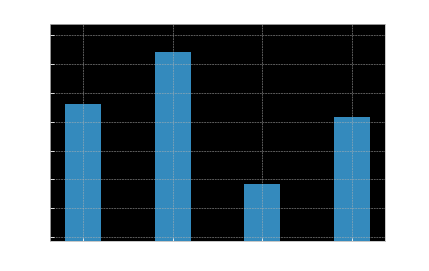

In [16]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison')